# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [1]:
import torch

if torch.backends.mps.is_available():
    print("✅ MPS is available and can be used!")
else:
    print("❌ MPS is not available on this system.")


✅ MPS is available and can be used!


In [ ]:
# Uncomment and run if required
#!pip install transformers torchvision torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 11.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.7.1
    Uninstalling torch-2.7.1:━━━━━━━━━━━━━━━━━━━ 0/3 [torch]
      Successfully uninstalled torch-2.7.1━━━━━━ 0/3 [torch]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [accelerate]3 [accelerate]]


In [ ]:
#pip show transformers

Name: transformers
Version: 4.53.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /Applications/miniconda3/envs/dsi_participant/lib/python3.9/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [10]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model     = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False)

# Set model to evaluation mode, as we are not training it
clip_model.eval()

# Check for accelerators
device = "cpu" # Default to CPU
if torch.cuda.is_available():
    device = "cuda" # Use GPU if available
elif torch.backends.mps.is_available():
    device = "mps"

clip_model.to(device)

print(f"Using device: {device}")

Using device: mps


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [11]:
from torchvision import datasets
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,       
    download=True       
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_clip
)

If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

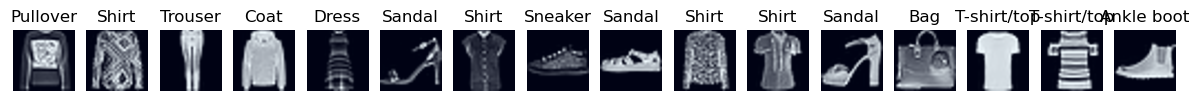

In [12]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [7]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)
    
    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [8]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    similarity = image_feats @ text_feats.T   # (N, D) @ (D, M) → (N, M)
    return similarity.numpy() 


def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    
    return similarity.argmax(axis=1)


With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

In [24]:
#from torch.utils.data import Subset

#sample_size = 10000
#sample_indices = list(range(sample_size))  # indices 0 to 499
#sample_dataset = Subset(test_dataset, sample_indices)

#sample_loader = DataLoader(
#    sample_dataset,
#    batch_size=16,
#    shuffle=True,
#    collate_fn=collate_clip
#)

#y_true, y_pred = [], []

#for pixel_values, labels in sample_loader:
#    image_feats = get_image_embeddings(pixel_values)
#    similarity = get_cosine_similarity(image_feats, text_feats)
#    preds = get_predictions(similarity)
#    y_true.extend(labels.numpy())
#    y_pred.extend(preds)

#  accuracy on the sample
#acc = accuracy_score(y_true, y_pred)
#print(f"Zero-shot CLIP accuracy on sample of {sample_size} images: {acc:.4f}")


Zero-shot CLIP accuracy: 0.6300


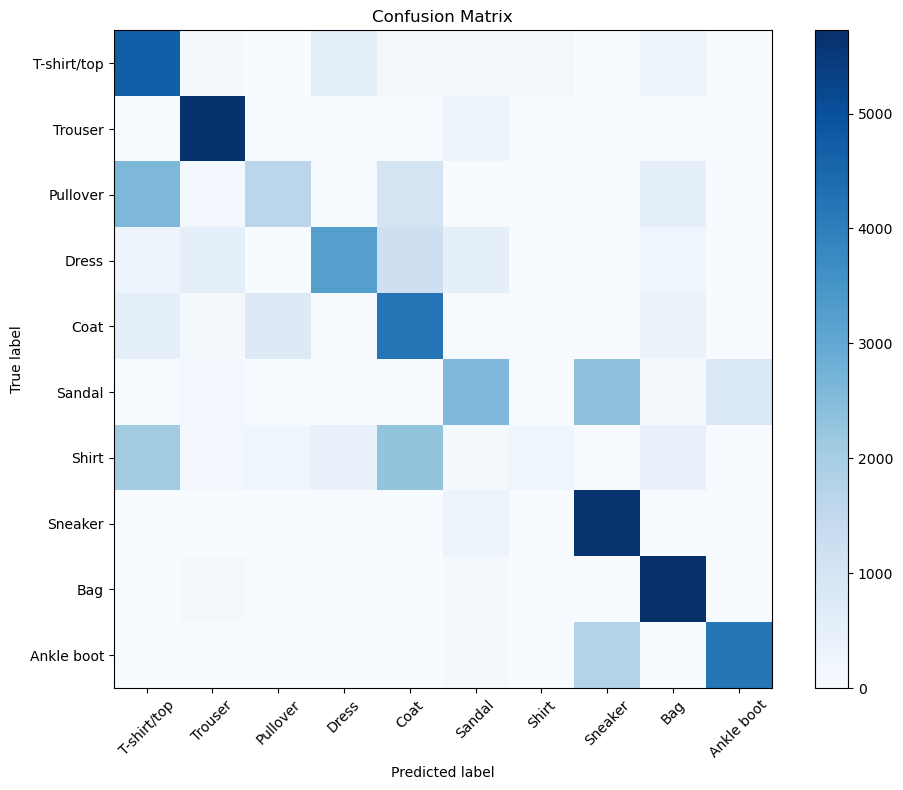

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

text_feats = get_text_embeddings(CLASS_NAMES)

y_true, y_pred = [], []

for pixel_values, labels in test_loader:

    # get embeddings
    image_feats = get_image_embeddings(pixel_values)

    # cosine similarity
    similarity = get_cosine_similarity(image_feats, text_feats)

    # predictions indices
    preds = get_predictions(similarity)

    # true & predicted labels
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# report the accuracy

acc = accuracy_score(y_true, y_pred)
print(f"Zero-shot CLIP accuracy: {acc:.4f}")


# Report the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)

Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach?

In [ ]:
# the zero-shot baseline (ZSB) performs lower Vs. CNN, which is to be expected since ZSB is more generalized.
# this makes it more powerful when tackling any dataset that doesnt have labeled examples for the model to learn from.
# but it performs lower Vs. CNN, which has especifically trained with this dataset. 

# ZSB offers a more generalizable and flexible solution, while CNN is more accurate and requires less computational power,
# but needs labeled examples as an input.

In [ ]:
# I also ran ZBS with a representative sample (subset), using less computational power, reached to the same conclusions
# as the ones when using the complete set.

## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

Zero-shot CLIP accuracy with improved prompts: 0.5896


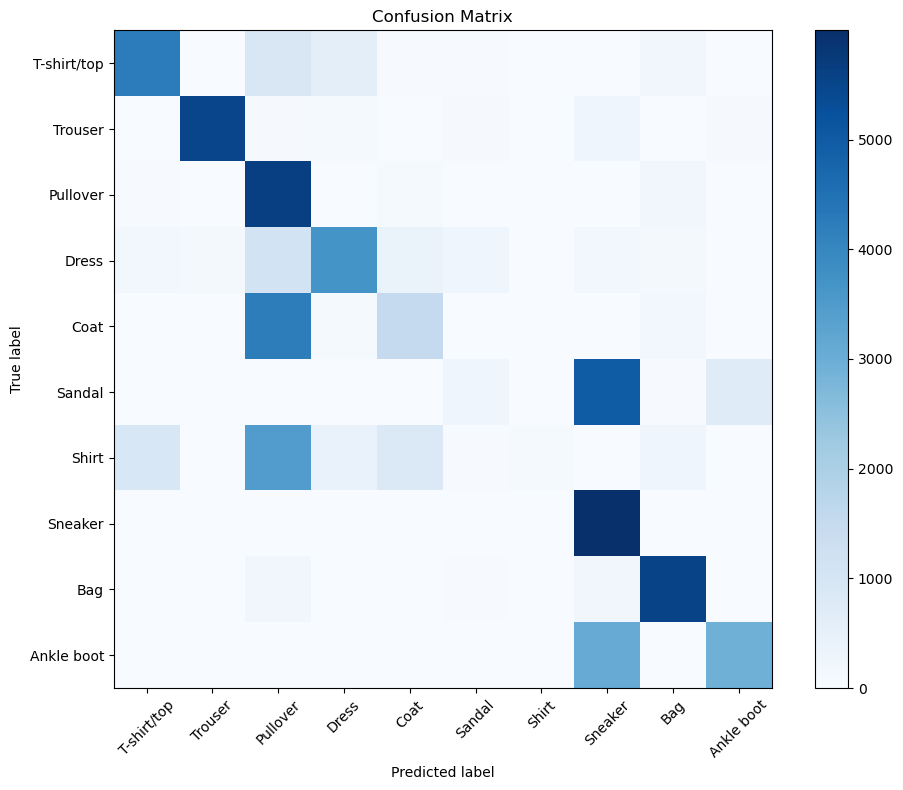

In [25]:
#list of improved prompts
improved_prompts = [
    "a photo of a T-shirt or top",   # T-shirt/top
    "a photo of trousers or pants",  # Trouser
    "a photo of a pullover or sweater", # Pullover
    "a photo of a dress",            # Dress
    "a photo of a coat or jacket",  # Coat
    "a photo of a sandal",           # Sandal
    "a photo of a shirt",            # Shirt
    "a photo of a sneaker or athletic shoe", # Sneaker
    "a photo of a bag or purse",     # Bag
    "a photo of an ankle boot"       # Ankle boot
]

#creating text embeddings for these prompts
text_feats_improved = get_text_embeddings(improved_prompts)

#running ZS

y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    # get embeddings
    image_feats = get_image_embeddings(pixel_values)

    # cosine similarity
    similarity = get_cosine_similarity(image_feats, text_feats_improved)

    # predictions
    preds = get_predictions(similarity)

    # results
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# acc
acc = accuracy_score(y_true, y_pred)
print(f"Zero-shot CLIP accuracy with improved prompts: {acc:.4f}")

# cnfusion matrix
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)


Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how?

In [ ]:
# it doesnt improve performance, nor i see a significant improvement vs baseline. Im sure with more effort
# the model will improve, but:

# Maybe the prompts where not relevantly improved.
# The data contained are simple greyscale images, which dont quite match vs the CLIP images and its descriptors

# We could try to use multiple prompts per class to see if acc raises.
# Maybe we could find a way to better adapt the CLIP vs MNIST data.

## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [ ]:
# Uncomment the following line to install UMAP if you haven't already
#!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 11.3 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [umap-learn]n]


In [36]:
all_img_emb = []
all_labels = []

for pixel_values, labels in test_loader:
    image_feats = get_image_embeddings(pixel_values)
    all_img_emb.append(image_feats.cpu().numpy())
    all_labels.append(labels.numpy())

# Convert to single arrays
all_img_emb = np.concatenate(all_img_emb, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


In [ ]:
#saving
#import torch


#torch.save(all_img_emb, "all_img_emb.pt")
#torch.save(all_labels, "all_labels.pt")
#torch.save(clip_model.state_dict(), "clip_model_state.pt")



In [1]:
# Load embeddings
import torch
all_img_emb = torch.load("all_img_emb.pt", weights_only=False)
all_labels = torch.load("all_labels.pt", weights_only= False)



Collected image embeddings: (60000, 512)
Collected labels: (60000,)


/Applications/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP reduced embeddings shape: (60000, 2)


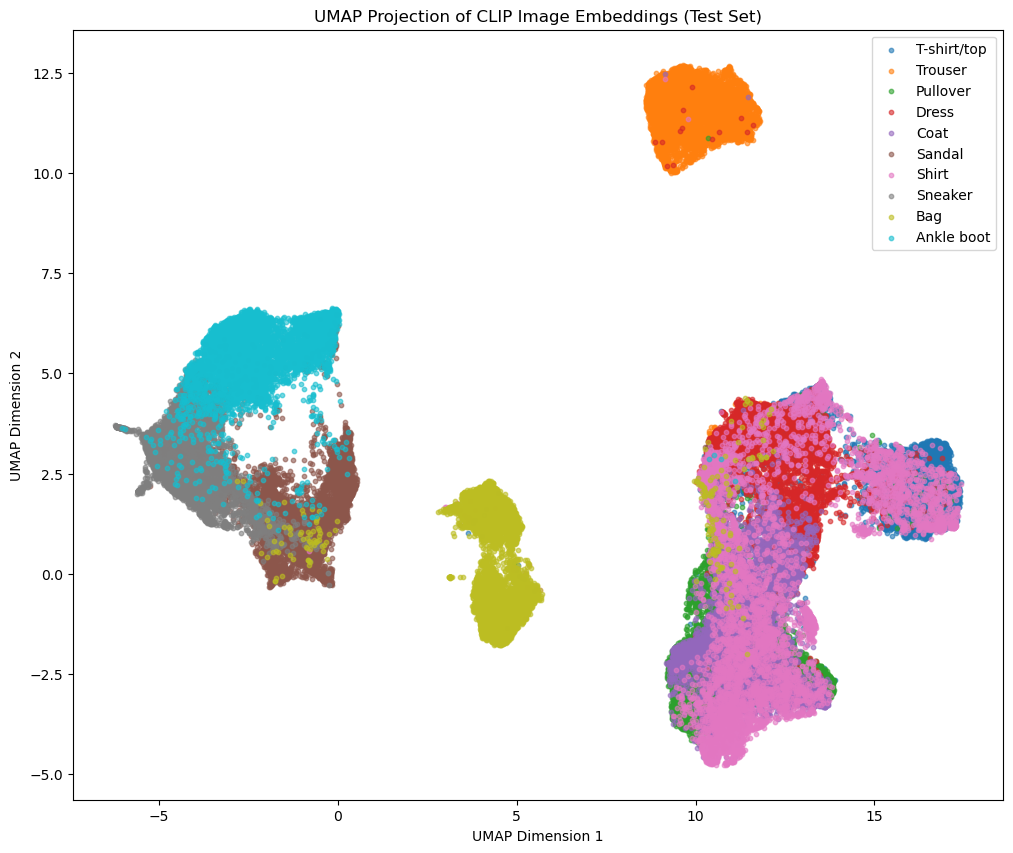

In [4]:
from umap import UMAP
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1. Collect image embeddings
# ------------------------------------------------------------

print("Collected image embeddings:", all_img_emb.shape)
print("Collected labels:", all_labels.shape)

# ------------------------------------------------------------
# 2. Fit UMAP
# ------------------------------------------------------------
umap_model = UMAP(n_components=2, random_state=42)
img_emb_2d = umap_model.fit_transform(all_img_emb)

print("UMAP reduced embeddings shape:", img_emb_2d.shape)

# ------------------------------------------------------------
# 3. Plot coloured by ground-truth label
# ------------------------------------------------------------

plt.figure(figsize=(12, 10))

cmap = plt.get_cmap('tab10')  # 10 colors for 10 classes

for class_idx, class_name in enumerate(CLASS_NAMES):
    indices = all_labels == class_idx
    plt.scatter(img_emb_2d[indices, 0],
                img_emb_2d[indices, 1],
                label=class_name,
                alpha=0.6,
                s=10,
                color=cmap(class_idx))

plt.title("UMAP Projection of CLIP Image Embeddings (Test Set)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()


The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph. 

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?



In [ ]:
#Yes al footware, can be mixed up. also dress vs coats. shirts vs tshirts.



## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

Zero-shot accuracy with laion/CLIP-ViT-B-32-laion2B-s34B-b79K: 0.624


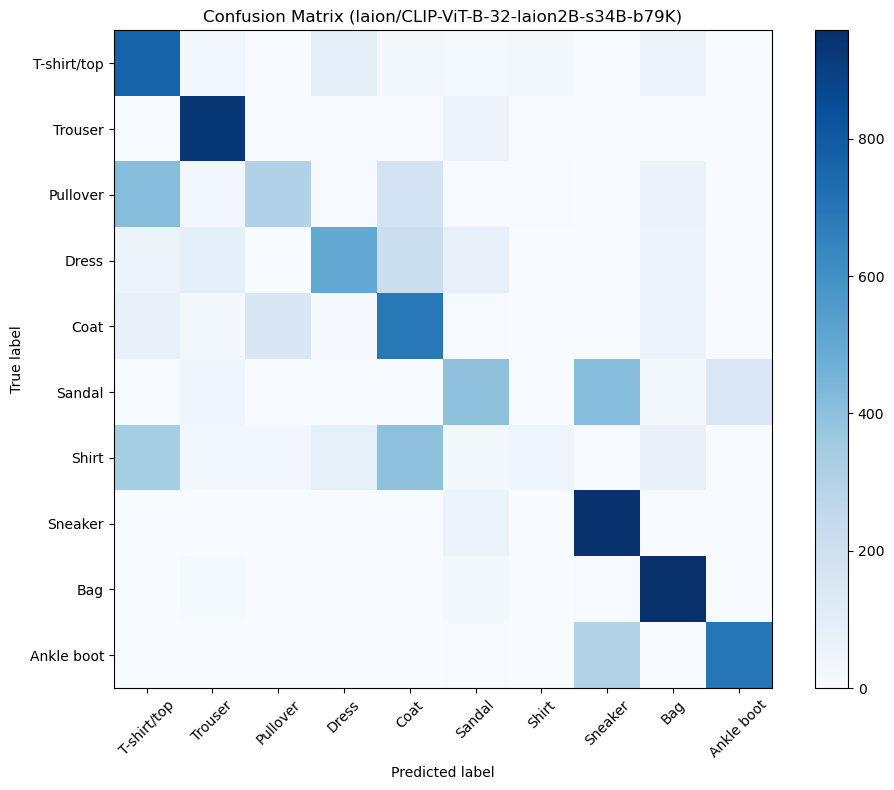

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


new_clip_model_name = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"

# ------------------------------------------------------------
# 1. Get text embeddings for class names (same as before)
# ------------------------------------------------------------
text_feats = get_text_embeddings(CLASS_NAMES)

# ------------------------------------------------------------
# 2. Loop over test batches and collect predictions
# ------------------------------------------------------------
y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    image_feats = get_image_embeddings(pixel_values)
    similarity = get_cosine_similarity(image_feats, text_feats)
    preds = get_predictions(similarity)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# ------------------------------------------------------------
# 3. Compute metrics
# ------------------------------------------------------------
acc = accuracy_score(y_true, y_pred)
print(f"Zero-shot accuracy with {new_clip_model_name}: {acc:.3f}")

# ------------------------------------------------------------
# 4. Plot confusion matrix
# ------------------------------------------------------------
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({new_clip_model_name})")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)


### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

In [ ]:
#-----------------------------
#Introduction:
# I went for the first experiment, to use an alternative CLIP model. The idea is to compare it with the original CLIP
# we were using and see if performance changed vs it, and vs the CNN model we used in assignment 1.

#-----------------------------
#Methodology:
#Loading Fashion-MNIST to then process them with the CLIP's processor.
#The CLIP model is used first, with the raw class names as prompts. 
#Image and text embeddings were generated using CLIP’s vision and text encoders
#and cosine similarity was computed to determine the predicted class.
#Accuracy and confusion matrices were computed with sklearn.metrics.

#-----------------------------
#Results:
#Baseline CLIP: Accuracy = 0.63
#Prompt-engineered CLIP: Accuracy = 0.58
#Alternative CLIP: Accuracy = 0.62
#CNN in Assignment 1 = ~0.85

#The confusion matrices showed that visually similar categories such as Shirt, 
#T-shirt/top, and Pullover were often misclassified, while distinct items like 
#Trouser and Bag were better recognized. 
#Shirt for instance, wasnt accurately classified in any CLIP version, slighly better in the last CLIP.
#-----------------------------
#Discussion:
#the experiment finally consolidates both strengths and weaknesses of CLIP models.
#CLIP shows impressive generalization without task-specific training, ideal for large-scale 
#models letting achieve reasonable accuracy on a dataset it was never trained on. (~0.6)

#Nevertheless, CLIP underperforms compared to a supervised CNN trained directly on Fashion-MNIST,
#which achieved >0.80 accuracy. CLIP struggles with distinctions between similar types of clothes
#because its embeddings capture broader concepts rather than detailed texture or shape.
#Prompt improvements did not significantly improve accuracy, likely because Fashion-MNIST images 
#are grayscale not comparable vs CLIP, trained on natural color images.




🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 02/11/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.